In [1]:
import pandas as pd
import numpy as np
import random
from sklearn import metrics
from sklearn.metrics import (roc_auc_score, precision_score, average_precision_score, recall_score,f1_score, accuracy_score,mean_squared_error,mean_absolute_error, roc_curve, auc, classification_report,auc,confusion_matrix,matthews_corrcoef)
from sklearn import logger
from sklearn.datasets import make_blobs,make_multilabel_classification
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import KernelCenterer,LabelEncoder, MinMaxScaler, Normalizer, QuantileTransformer, RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, StandardScaler
from sklearn.manifold import TSNE
import time
from sklearn.metrics import confusion_matrix,classification_report
import scipy as sp
from scipy.linalg import svd,null_space
import os
from sklearn.metrics.pairwise import pairwise_kernels
from sklearn.cluster import KMeans,AgglomerativeClustering,SpectralClustering
from sklearn.mixture import GaussianMixture
from scipy.sparse import csr_matrix as sp
import math
from scipy.sparse.linalg import svds
from scipy.spatial.distance import cdist
from mpl_toolkits.mplot3d import Axes3D  # Import 3D plotting tools
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture



In [2]:

# Hàm	Độ phức tạp tính toán	Bộ nhớ cần
# preprocess_data_OC	O(n⋅d²)	O(n⋅d²)
# clusterr	O(n⋅d⋅k⋅iters)	O(n⋅d)
# nullspace	O(d³)	O(d²)
# gram_schmidt	O(d³)	O(d²)
# minimum_distance	O(n⋅m⋅d)	O(n⋅m)
# distance_vector	O(n⋅m⋅d)	O(n⋅m)
# calculate_NPD	O(d³)	O(d²)
# learn	O(n²⋅d)	O(n²)

random.seed(42)

eps = 1e-9
alpha = 0.9 

In [3]:

def preprocess_data_noise(train_data, test_data, noise_percentage=0):
  
    print("..............................Data Overview................................")
    print("Train Data Shape:", train_data.shape)
    print("Test Data Shape:", test_data.shape)
    
    # Convert to numpy arrays for easier manipulation
    X_train_total = train_data.iloc[:, :-1].to_numpy()
    y_train_total = train_data.iloc[:, -1].to_numpy()

    # Separate the samples with label 0
    X_train = X_train_total[y_train_total == 0]
    y_train = y_train_total[y_train_total == 0]

    print("Train Data Labels [0]:", np.unique(y_train))

    # Calculate how many samples to add noise to based on the provided percentage
    n_samples = X_train.shape[0]
    noise_samples_count = int(n_samples * (noise_percentage / 100))

    # Get the samples with label 1 (for generating noise)
    X_train_noise = X_train_total[y_train_total == 1]
    
    # Randomly select noise_samples_count from X_train_noise
    noisy_indices = np.random.choice(X_train_noise.shape[0], size=noise_samples_count, replace=False)
    X_train_noise = X_train_noise[noisy_indices]
    
    # Add the noisy samples to the training set
    X_train = np.vstack((X_train, X_train_noise))
    y_train = np.concatenate((y_train, np.ones(X_train_noise.shape[0])))
    print(y_train) 
    
    # Prepare test data
    X_test = test_data.iloc[:, :-1].to_numpy()
    y_test = test_data.iloc[:, -1].to_numpy()

    # Print the new size of training data
    n_samples = X_train.shape[0]
    n_features = X_train.shape[1]
    print("Number of samples after adding noise:", n_samples)
    print("Number of features:", n_features)

    return X_train, y_train, X_test, y_test

def cluster_kmeans(data, initial_k):
    print("Starting K-Means clustering...")

    # Thực hiện K-Means clustering với số cụm initial_k
    kmeans = KMeans(n_clusters=initial_k, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(data)

    # Gán nhãn cụm vào biến labels
    labels = cluster_labels

    # Sắp xếp dữ liệu theo nhãn cụm
    sorted_indices = np.argsort(labels)
    sorted_data = data[sorted_indices]
    sorted_labels = labels[sorted_indices]

    print("Final number of clusters:", len(np.unique(sorted_labels)))
    return sorted_data, sorted_labels


In [4]:
def nullspace(A):
    _, s, vh = np.linalg.svd(A)
    null_mask = np.isclose(s, 0)
    null_space = vh[null_mask].T
    return null_space


def minimum_distance( A, B):
        """
        Compute the minimum Euclidean distance from each point in A to all points in B.
        
        Parameters:
        - A (ndarray): Set of points (N_A, d).
        - B (ndarray): Set of points (N_B, d).
        
        Returns:
        - min_distances (ndarray): Minimum distances from each point in A to the nearest point in B.
        """
        A = np.asarray(A)
        B = np.asarray(B)
        
        # Initialize an array for storing minimum distances
        min_distances = np.empty(A.shape[0], dtype=np.float64)
        
        # Iterate over each point in A and calculate minimum distance to points in B
        for i, a in enumerate(A):
            distances = cdist([a], B, metric='euclidean')  # Compute all pairwise distances
            min_distances[i] = np.min(distances)  # Store minimum distance
        
        return min_distances   

def distance_vector(point_X, point_Y):
    """
    Calculate pairwise Euclidean distance between two sets of points.
    
    Args:
        point_X (ndarray): Array of shape (N_train, d) where N_train is the number of training samples and d is the number of features.
        point_Y (ndarray): Array of shape (N_test, d) where N_test is the number of test samples and d is the number of features.
        
    Returns:
        ndarray: Distance matrix of shape (N_test, N_train) containing Euclidean distances between each pair of points.
    """
    print( 'Complexity of calculate: ', point_X )
    # Compute squared norms for each point
    norm_X = np.sum(point_X**2, axis=1)  # (N_train,)
    norm_Y = np.sum(point_Y**2, axis=1)  # (N_test,)
    
    # Compute the dot product between the two sets of points
    dot_product = np.dot(point_Y, point_X.T)  # (N_test, N_train)
    
    # Apply Euclidean distance formula
    distance = np.sqrt(abs(norm_Y[:, np.newaxis] + norm_X[np.newaxis, :] - 2 * dot_product))
    return distance



def calculate_NPD(X,y):
    print("Begin calculating NPD --------------")
    X = X.T
    print('shape of X', X.shape)
    c = len(np.unique(y))  # Số lớp
    d, N = X.shape  # Số đặc trưng và số mẫu
    # Tính trung bình toàn cục và tạo ma trận P_t với zero-mean
    mean_total = np.mean(X, axis=1, keepdims=True)
    P_t = X - mean_total  # P_t là ma trận zero-mean có kích thước d x N
    
    # Tính P_w cho từng lớp
    P_w = np.zeros_like(X)
    for i in range(c):
        class_mean = np.mean(X[:, y == i], axis=1, keepdims=True)
        P_w[:, y == i] = X[:, y == i] - class_mean  # Tạo ma trận P_w có kích thước d x N
        
    # Tính ma trận phương sai S_w và S_t
    S_w = np.dot(P_w, P_w.T) / N  # S_w là d x d
    S_t = np.dot(P_t, P_t.T) / N  # S_t là d x d

    U, S, Vt = np.linalg.svd(P_t, full_matrices=False)
    Q = U
    B = nullspace(Q.T @ S_w @ Q)
    W = Q @ B  # W có kích thước d x (c - 1)

    # In kết quả
    print("N =", N,  "  d =", d, "   c =", c )
    print("P_w : d x N =", P_w.shape)  # d x N
    print("P_t : d x N =", P_t.shape)  # d x N
    print("S_w : d x d =", S_w.shape)  # d x d
    print("S_t : d x d =", S_t.shape)  # d x d
    print("Q   : d x N =", Q.shape)     # d x r
    print("B   : N x L =", B.shape)     # r x L
    print("W   : d x L =", W.shape)     # d x L
    return W    

    

def BruteForce_Threshold(y_true, y_prob, minth=0.0, maxth=1.0, num_thresholds=1000):
    """
    Finds the best classification threshold for a binary model using brute force search.

    Args:
        y_true (ndarray): True labels (0 or 1), shape (n_samples,).
        y_prob (ndarray): Predicted probabilities for class 1, shape (n_samples,).
        minth (float, optional): Minimum threshold value. Default is 0.0.
        maxth (float, optional): Maximum threshold value. Default is 1.0.
        num_thresholds (int, optional): Number of threshold values to search. Default is 1000.

    Returns:
        dict: Dictionary containing the best threshold for each evaluation metric.
    """
    thresholds = np.linspace(minth, maxth, num_thresholds)  # Generate candidate thresholds

    # Initialize best metrics
    best_results = {
        "accuracy": (0, 0),  # (best_threshold, best_score)
        "f1": (0, 0),
        "mcc": (0, 0),
        "auc_roc": (0, 0),
        "auc_pr": (0, 0)
    }

    return best_results 
    for threshold in thresholds:
        y_pred = (y_prob[:,1] >= threshold).astype(int)

        # Compute evaluation metrics
        acc = accuracy_score(y_true, y_pred)
        f1 = f1_score(y_true, y_pred)
        mcc = matthews_corrcoef(y_true, y_pred)
        auc_roc = roc_auc_score(y_true, y_prob[:, 1])
        auc_pr = average_precision_score(y_true, y_prob[:, 1])

        # Update best threshold for each metric
        if acc > best_results["accuracy"][1]:
            best_results["accuracy"] = (threshold, acc)
        if f1 > best_results["f1"][1]:
            best_results["f1"] = (threshold, f1)
        if mcc > best_results["mcc"][1]:
            best_results["mcc"] = (threshold, mcc)
        if auc_roc > best_results["auc_roc"][1]:
            best_results["auc_roc"] = (threshold, auc_roc)
        if auc_pr > best_results["auc_pr"][1]:
            best_results["auc_pr"] = (threshold, auc_pr)

    return best_results


def learn( npd, X_train, y_train , X_test, t0):
    '''
    X_train n1, d 

    C: n * n * d 
    '''
    print( "npd ::: " , npd.shape ) 
    t1 = time.time()
    null_point_X = (sp(X_train).dot(sp(npd))).toarray()
    null_point_X_test = (sp(X_test).dot(sp(npd))).toarray()  

    plot_data_2D(null_point_X, y_train, "Du lieu sau projection") 

    train_score_tmp = distance_vector(null_point_X, null_point_X)
    for i in range(len(train_score_tmp)):
        train_score_tmp[i , i] = 1e9                                                      
    train_score = np.amin(train_score_tmp, axis=1)
    
    y_score = minimum_distance(null_point_X_test, null_point_X)
    y_proba = np.zeros((len(y_score), 2))
    y_proba[:, 1] = np.minimum(y_score / np.max(train_score), 1)                         
    y_proba[:, 0] = 1 - y_proba[:, 1]                                                     # Probability for class 0
    
    y_proba = np.nan_to_num(y_proba, nan=1.0)

    y_predict = (y_proba[:, 1] > 0.2).astype(int) 
    
    
    
    t2 = time.time()
    print("...............................Timing Model................................")
    print("Time train:", t1-t0)
    print("Time test:" , t2-t1)
    return y_proba, y_predict, t1, t2  


def Model_evaluating(y_true, y_predict, y_scores):
    """
    Evaluate the model using various metrics such as AUC, AUCPR, Accuracy, MCC, F1-score, Precision, and Recall.
    
    Args:
        y_true (ndarray): True labels.
        y_predict (ndarray): Predicted labels.
        y_scores (ndarray): Predicted probabilities for each class.
        
    Returns:
        list: List of evaluation metrics.
    """
    print("..............................Report Parameter...............................")
    
    # Calculate MCC (Matthews Correlation Coefficient)
    mcc = matthews_corrcoef(y_true, y_predict)
    
    # Calculate F1 score
    f1 = f1_score(y_true, y_predict)
    
    # Calculate PPV (Positive Predictive Value) or Precision
    ppv = precision_score(y_true, y_predict)
    
    # Calculate TPR (True Positive Rate) or Recall/Sensitivity
    tpr = recall_score(y_true, y_predict)
    
    # Calculate Accuracy
    accuracy = accuracy_score(y_true, y_predict)
    
    # Calculate AUC (Area Under ROC Curve)
    AUC = roc_auc_score(y_true, y_scores[:, 1])
    
    # Calculate AUCPR (Area Under Precision-Recall Curve)
    AUCPR = average_precision_score(y_true, y_scores[:, 1])
    
    # Print out the evaluation metrics
    print("AUCROC:", AUC * 100)
    print("AUCPR:", AUCPR * 100)
    print("Accuracy:", accuracy * 100)
    print("MCC:", mcc)
    print("F1 score:", f1)
    print("PPV (Precision):", ppv)
    print("TPR (Recall):", tpr)

    return [AUC * 100 if AUC else None, AUCPR * 100 if AUCPR else None,
            accuracy * 100, mcc, f1, ppv, tpr]



In [5]:
# X_train, y_train, X_test, y_test = preprocess_data_OC(df2, df1)

# X_total = np.vstack((X_train, X_test))
# unique_rows = np.unique(X_total, axis=0)

# print("Số dòng trong X_total:", X_total.shape[0])   # Output: 5
# print("Số dòng khác nhau:", unique_rows.shape[0])  

In [6]:

import pandas as pd

# Load the CSV files from the GMM-nfst folder

# columns = ["Dataset","Model",  "scaled", "noise_percentage", "AUCROC", "AUCPR", "Accuracy", "MCC", "F1 Score",
#            "Precision", "Recall", "Time Train", "Time Test"]

columns = ["outlier_mode", 'scaler', "nCluster", "AUCROC", "AUCPR", "Accuracy", "MCC", "F1 Score",
           "Precision", "Recall", "Time Train", "Time Test"]
# Now you can use df1 and df2 as DataFrames

#CIC_IoT2023_1000.csv
#N_BaIoT_1000.csv
#BoT_IoT_1000.csv

import cProfile
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np


# def plot_data_2D(X, labels, title="Interactive 3D PCA Plot"):
#     """ Vẽ dữ liệu với PCA và tạo đồ thị 3D có thể tương tác bằng Plotly """

#     # Ensure that n_components ≤ min(n_samples, n_features)
#     n_components = min(3, X.shape[0], X.shape[1])
#     if n_components < 3:
#         print(f"⚠️ Warning: Cannot plot 3D, because n_components={n_components}. Skipping...")
#         return
    
#     # Perform PCA
#     pca = PCA(n_components=3)
#     X_3D = pca.fit_transform(X)

#     # Convert labels to a NumPy array
#     labels = np.array(labels)

#     # Create a DataFrame for better visualization
#     import pandas as pd
#     df = pd.DataFrame(X_3D, columns=['PCA 1', 'PCA 2', 'PCA 3'])
#     df['Class'] = labels

#     # Create an interactive 3D scatter plot
#     fig = px.scatter_3d(df, x='PCA 1', y='PCA 2', z='PCA 3', 
#                          color=df['Class'].astype(str),  # Color by class
#                          title=title, labels={'color': 'Class'},
#                          opacity=0.8)

#     fig.update_traces(marker=dict(size=5))  # Adjust marker size
#     fig.show()

def plot_data_2D(X, labels, title="Dữ liệu gốc trước khi biến đổi"):
    """ Vẽ dữ liệu với PCA để giảm xuống 2D """
    # return 0 
    pca = PCA(n_components=3)
    X_2D = pca.fit_transform(X)  # Chuyển về dạng (100, 2)

    plt.figure(figsize=(8, 6))
    labels = np.array(labels)  
    for i in np.unique(labels):
        plt.scatter(X_2D[labels == i, 0], X_2D[labels == i, 1], label=f"Class {i}", alpha=0.7)

    plt.xlabel("PCA 1")
    plt.ylabel("PCA 2")
    plt.title(title)
    plt.legend()
    plt.grid()
    plt.show()


def function(df1,df2, outlier_mode, scaler):

    X_train0, y_train0, X_test, y_test = preprocess_data_noise( df1,df2, 0)

    for ncluster in range(291,min(400, X_train0.shape[0]), 5000):
        t0 = time.time()
        X_train , y_train = cluster_kmeans( X_train0 , ncluster )
        t5 = time.time() 
        plot_data_2D(X_train, y_train, "Du lieu sau clusterr") 
        npd = calculate_NPD(X_train, y_train)

        t4 = time.time() 

        print(" time to calculate NPD: " , t4 - t5) 
        
        y_proba, y_predict, t1, t2 = learn( npd , X_train, y_train, X_test, y_test)  #,y_predict
        
        # print("...............................Timing Model................................")
        # print("Time train:", t1-t0)
        # print("Time test:" , t2-t1)
        # print("...........................................................................")
        # print(y_predict)
        v = Model_evaluating(y_test, y_predict, y_proba)
        # best_thresholds = BruteForce_Threshold( y_test, y_proba, 0, 1)  
        result = [outlier_mode, scaler] + [ncluster] + v + [t1-t0, t2-t1]
        # for metric, (threshold, score) in best_thresholds.items():
        #     result = result + [threshold, score ]  

        result_df = pd.DataFrame([result], columns=columns)
        result_df.to_csv(output_file, mode='a', header=not os.path.exists(output_file), index=False)
        # result_df.to_csv(output_file, mode='a', header=(mark==0), index=False)
        
    return 0


--------------------------------------------------
-------- data_N_BaIoT.csv ------------------------------
--------------------------------------------------
⚠️ Error processing Datascaled/OutlierData/Train_cluster_RobustScaler_data_N_BaIoT.csv or Datascaled/OutlierData/Test_cluster_RobustScaler_data_N_BaIoT.csv: [Errno 2] No such file or directory: 'Datascaled/OutlierData/Train_cluster_RobustScaler_data_N_BaIoT.csv'
⚠️ Error processing Datascaled/OutlierData/Train_cluster_QuantileTransformer_data_N_BaIoT.csv or Datascaled/OutlierData/Test_cluster_QuantileTransformer_data_N_BaIoT.csv: [Errno 2] No such file or directory: 'Datascaled/OutlierData/Train_cluster_QuantileTransformer_data_N_BaIoT.csv'
..............................Data Overview................................
Train Data Shape: (3000, 116)
Test Data Shape: (7000, 116)
Train Data Labels [0]: [0]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0

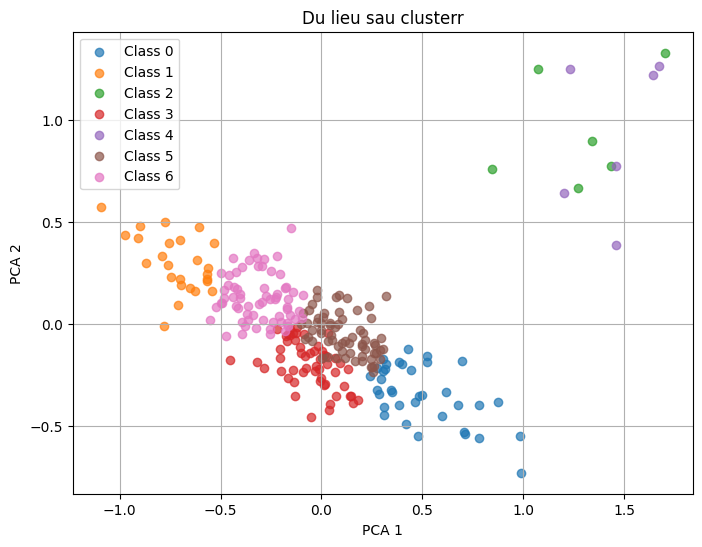

Begin calculating NPD --------------
shape of X (115, 261)
N = 261   d = 115    c = 7
P_w : d x N = (115, 261)
P_t : d x N = (115, 261)
S_w : d x d = (115, 115)
S_t : d x d = (115, 115)
Q   : d x N = (115, 115)
B   : N x L = (115, 0)
W   : d x L = (115, 0)
 time to calculate NPD:  3.950526714324951
npd :::  (115, 0)
⚠️ Error processing Datascaled/OutlierData/Train_cluster_MinMaxScaler_data_N_BaIoT.csv or Datascaled/OutlierData/Test_cluster_MinMaxScaler_data_N_BaIoT.csv: Found array with 0 feature(s) (shape=(261, 0)) while a minimum of 1 is required by PCA.
⚠️ Error processing Datascaled/OutlierData/Train_cluster_Normalizer_data_N_BaIoT.csv or Datascaled/OutlierData/Test_cluster_Normalizer_data_N_BaIoT.csv: Another profiling tool is already active
⚠️ Error processing Datascaled/OutlierData/Train_cluster_StandardScaler_data_N_BaIoT.csv or Datascaled/OutlierData/Test_cluster_StandardScaler_data_N_BaIoT.csv: Another profiling tool is already active
⚠️ Error processing Datascaled/OutlierDat

In [7]:
import cProfile
import pstats    

# dataset_prefixes =  ['N_BaIoT_dataloader.csv']
# dataset_prefixes =  ['data_CICIoT2023.csv', 'data_N_BaIoT.csv', 'data_BoTIoT.csv']
dataset_prefixes =  ['data_N_BaIoT.csv', 'data_ToNIoT.csv', 'data_CICIoT2023.csv', 'data_BoTIoT.csv']
# dataset_prefixes =  ['data_CICIoT2023.csv']


#  'data_N_BaIoT.csv',  
# scaler_names = ['MinMaxScaler']
scaler_names = ['RobustScaler',  'QuantileTransformer','MinMaxScaler','Normalizer','StandardScaler' ]
# scaler_names = ['MinMaxScaler','StandardScaler','QuantileTransformer','Normalizer']
outlier_modes = ['cluster', 'local', 'global']

for prefix in dataset_prefixes:
    
    print("-"*50)
    print("--------", prefix , "-"*30)
    print("-"*50)

    #  Structure_Result/NOISEGAU 
    base_output_file = f"Structure_Result/outlier_{prefix}" 
    output_file = base_output_file + "0.csv"

    # Increment the filename if it already exists
    counter = 0
    while os.path.exists(output_file):
        counter += 1
        output_file = f"{base_output_file}{counter}.csv"

        
    for outlier_mode in outlier_modes: 
        # print(f"Processing dataset {prefix} with {scaler} scaler ...")
        
        # Construct file paths for train and test datasets with 'Train_' and 'Test_' prefixes
        for scaler in scaler_names: 
            train_file = f'Datascaled/OutlierData/Train_{outlier_mode}_{scaler}_{prefix}'
            test_file = f'Datascaled/OutlierData/Test_{outlier_mode}_{scaler}_{prefix}'

            # train_file = f'Datascaled/Train_{scaler}_{prefix}'
            # test_file = f'Datascaled/Test_{scaler}_{prefix}'

            try:
                # Load the CSV files
                df_train = pd.read_csv(train_file)
                df_test = pd.read_csv(test_file)

                log_file = f'Results/OURMODEL/SCALERS/{prefix}_modellog.txt'
                with open(log_file, "w") as f:
                    profiler = cProfile.Profile()
                    profiler.enable()
                    
                    function(df_train, df_test, outlier_mode, scaler)  # Chạy hàm cần profile
                
                    profiler.disable()
                    stats = pstats.Stats(profiler, stream=f)
                    stats.sort_stats("cumulative").print_stats()
            
            except Exception as e:
                print(f"⚠️ Error processing {train_file} or {test_file}: {e}")
                continue